In [1]:
import gc
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from helpers.funcs import resample, single_ts_split, timeseries_train_test_split as TSSplit, fit_model_cv, plotCoefficients
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import pmdarima as pm
%matplotlib inline
NB_SEED = 123123

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  retu

In [2]:
def setindexdatetime(df, index_col):
    df[index_col] = pd.to_datetime(df[index_col])
    df.set_index(index_col, inplace=True)
    df = df.astype(np.float)
    return df

In [3]:
tr = setindexdatetime(pd.read_csv('valids/v_ready_iqr_tr.csv'),'Timestamp')
ts = setindexdatetime(pd.read_csv('valids/v_ready_iqr_ts.csv'),'Timestamp')
tr.index.freq = '15T'
ts = resample(ts)

/home/berkkarahan/Desktop/tupras/helpers/funcs.py:38: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  tseries.index[0], pd.tslib.Timestamp), 'Object must have a datetime-like index.'
/home/berkkarahan/Desktop/tupras/helpers/funcs.py:72: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  tseries = tseries.resample(short_rate, how='mean').interpolate()
/home/berkkarahan/Desktop/tupras/helpers/funcs.py:75: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  tseries = tseries.resample(rate, how='ffill')


In [4]:
f = ((24*60)//15)
sd = seasonal_decompose(tr.Target, freq=f)

In [5]:
def make_sd_plots(sd, figsize=(40,20), save=False):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=figsize)
    ax1.plot(sd.observed, label='observed')
    plt.legend(loc='upper left')
    ax2.plot(sd.trend, label='trend')
    plt.legend(loc='upper left')
    ax3.plot(sd.seasonal, label='seasonal')
    plt.legend(loc='upper left')
    ax4.plot(sd.resid, label='residual')
    plt.legend(loc='upper left')
    plt.title('Seasonal Decomposition')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


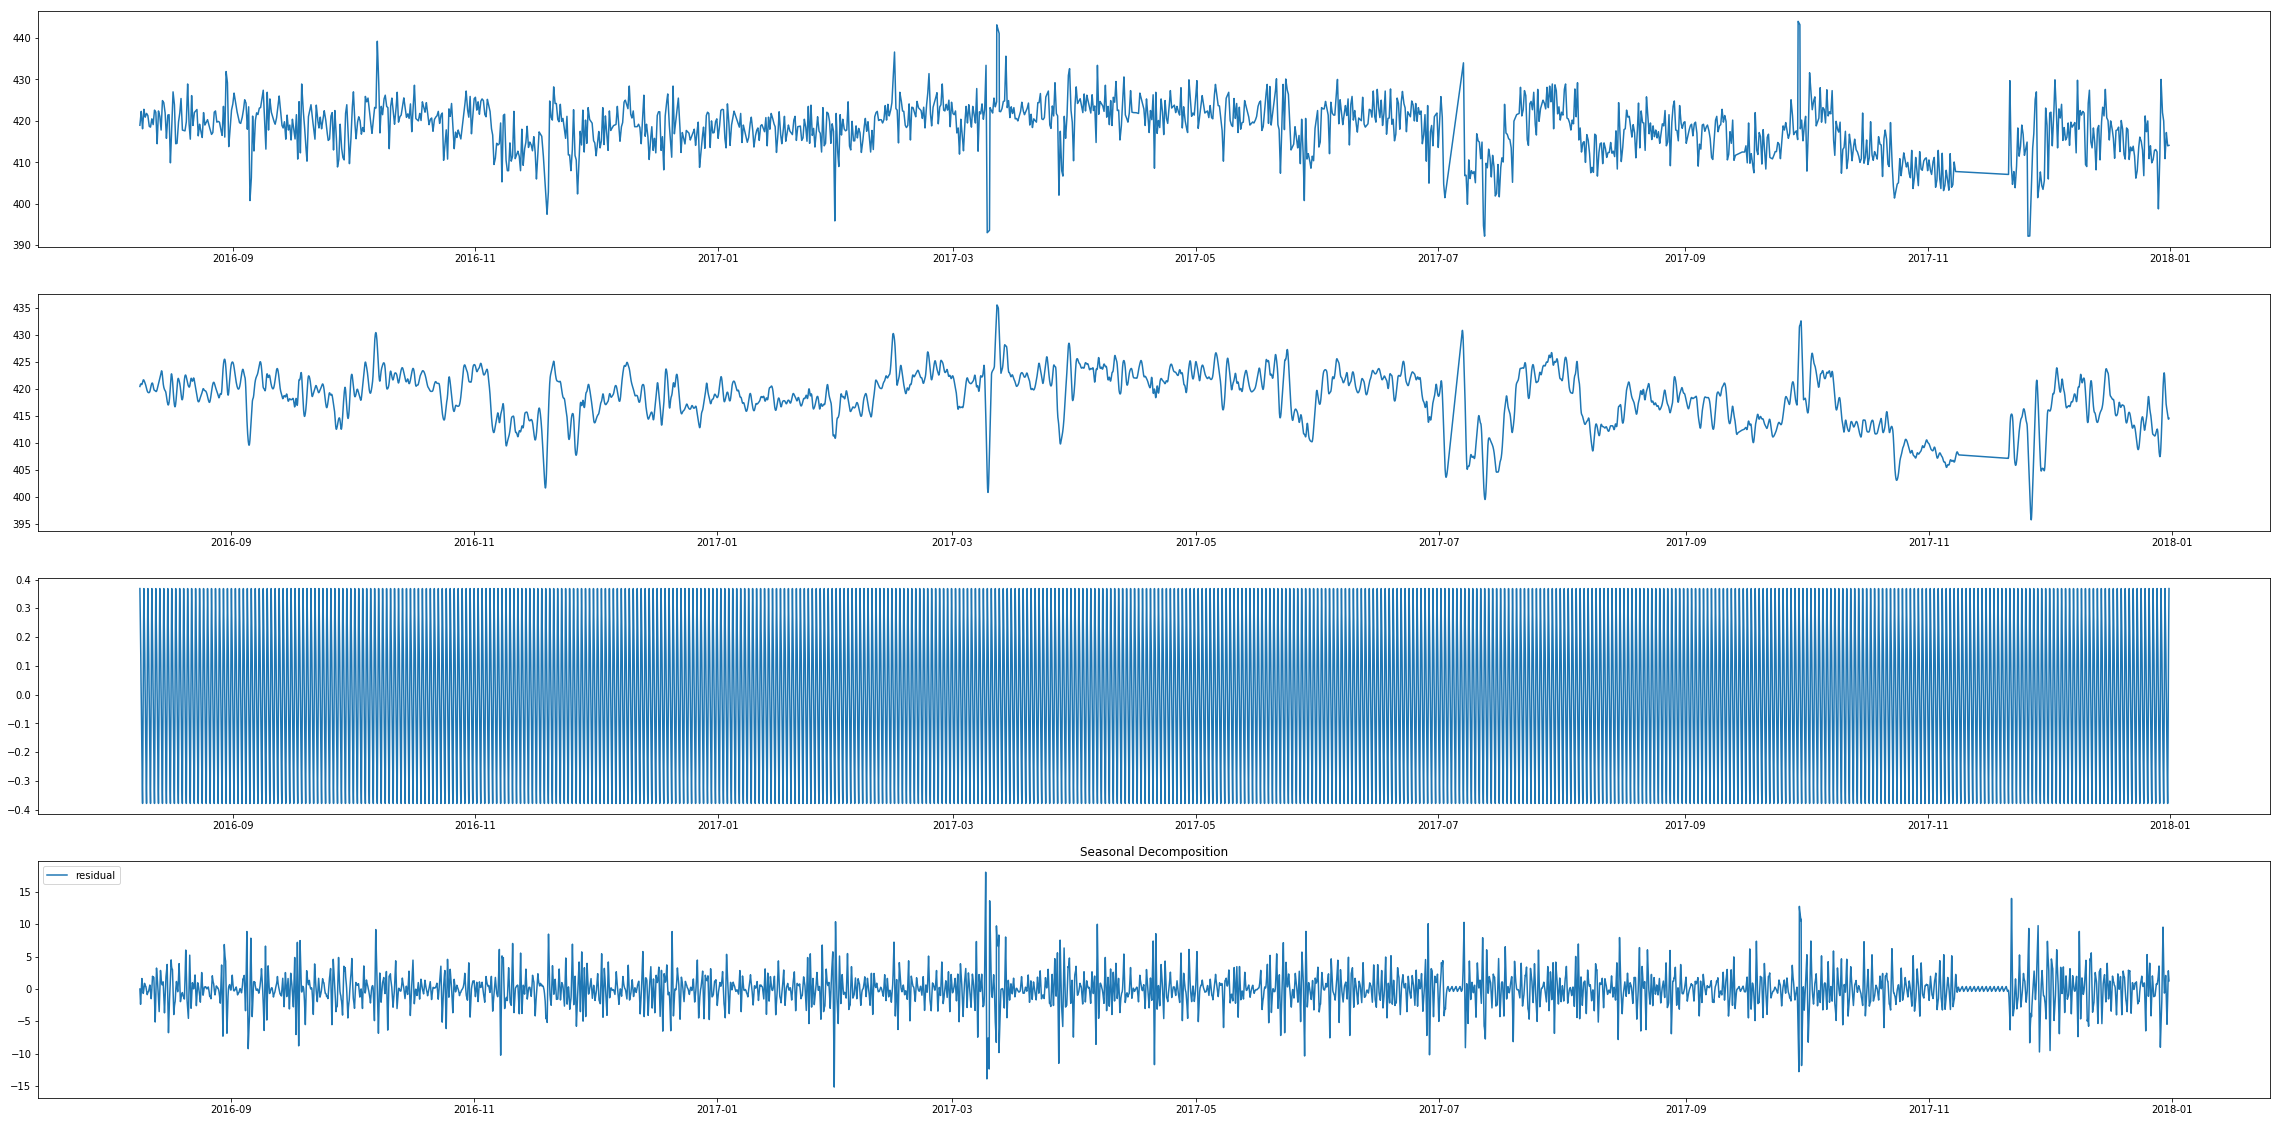

In [6]:
make_sd_plots(sd)

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window=12):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(30, 20))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

In [8]:
def difference_n(timeseries, n):
    timeseries = timeseries - timeseries.shift(n)
    return timeseries.dropna()

In [9]:
#hourly freq series
hourly = tr.Target.copy().resample('H', base=00).interpolate(how='time')
#6hrly freq series
hourly_6 = tr.Target.copy().resample('6H', base=00).interpolate(how='time')
#12hrly freq series
hourly_12 = tr.Target.copy().resample('12H', base=00).interpolate(how='time')
#daily freq series
daily = tr.Target.copy().resample('D').interpolate(how='time')

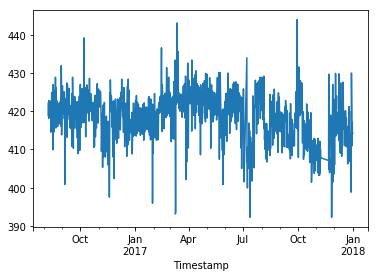

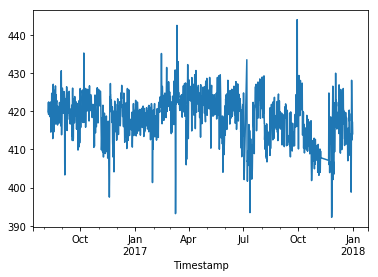

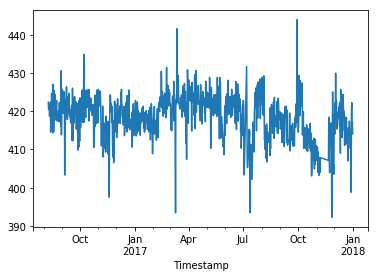

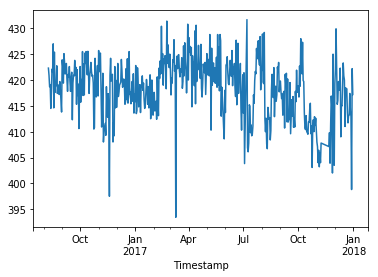

In [10]:
hourly.plot()
plt.show()
hourly_6.plot()
plt.show()
hourly_12.plot()
plt.show()
daily.plot()
plt.show()

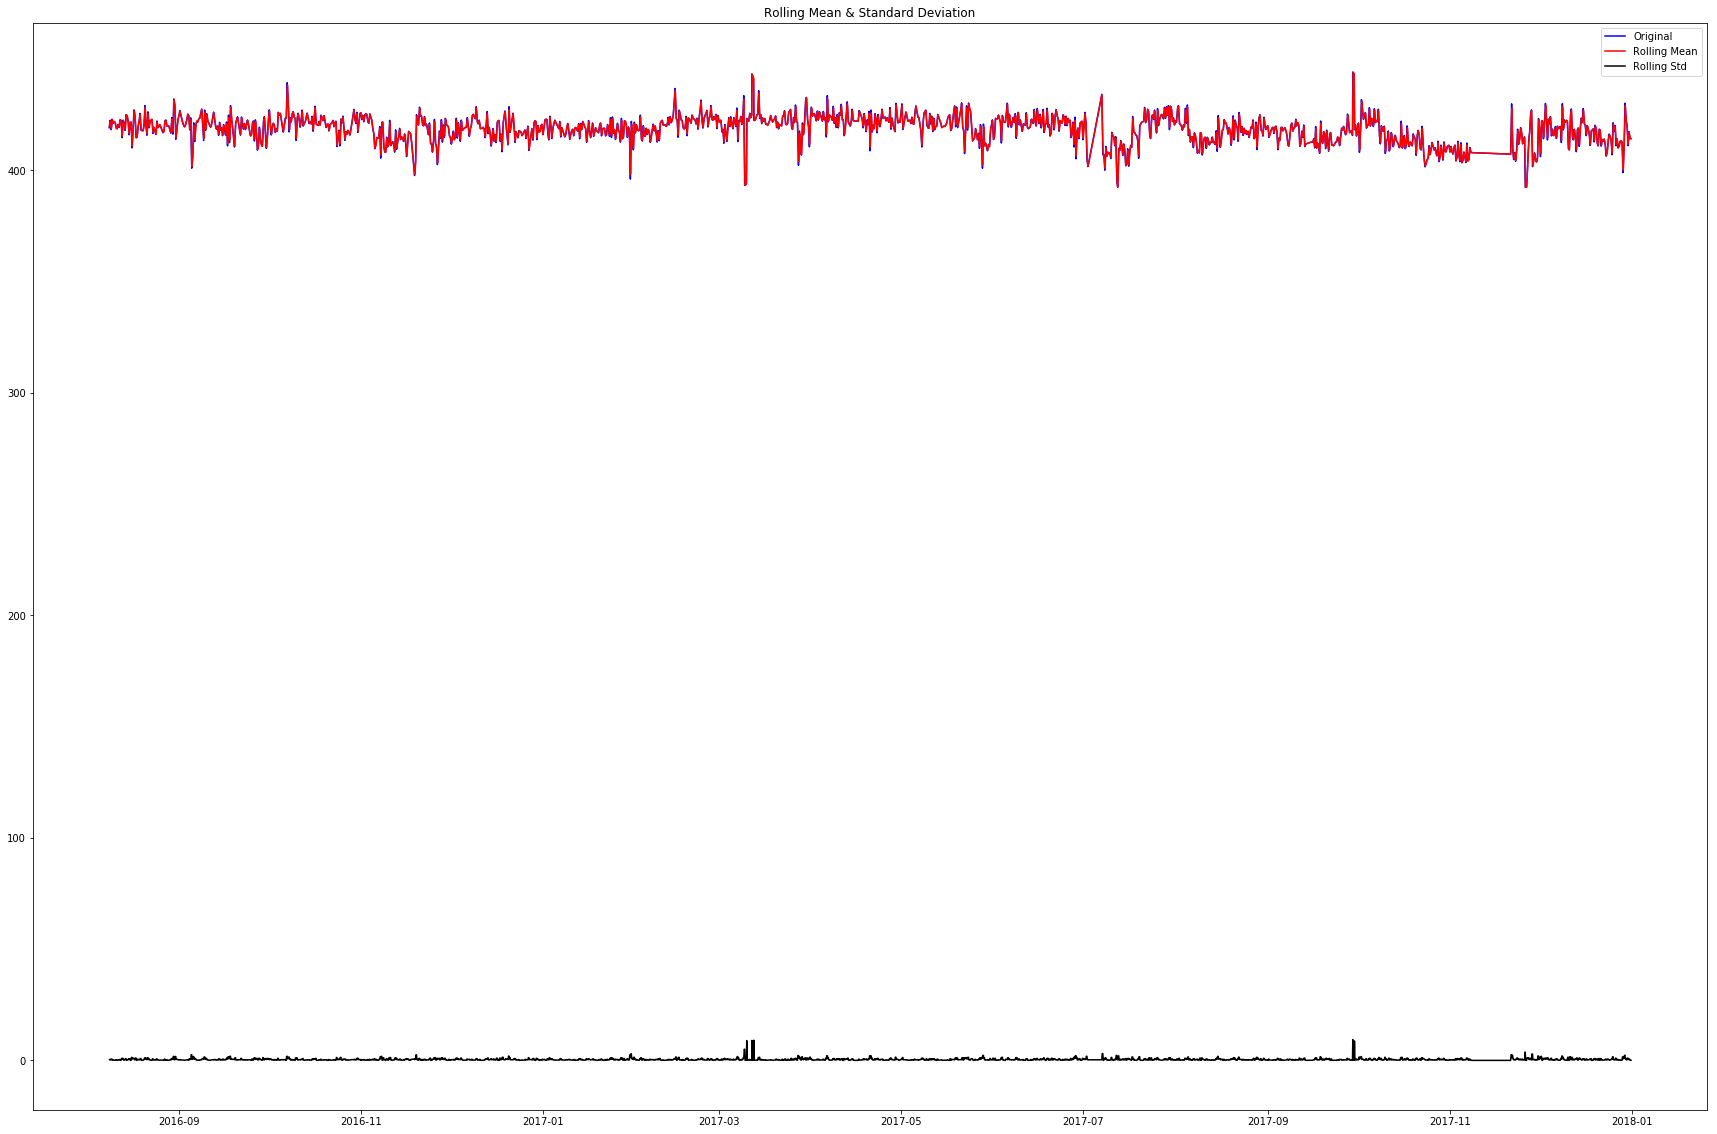

Results of Dickey-Fuller Test:
Test Statistic                -1.154172e+01
p-value                        3.621034e-21
#Lags Used                     5.600000e+01
Number of Observations Used    4.890400e+04
Critical Value (1%)           -3.430484e+00
Critical Value (5%)           -2.861599e+00
Critical Value (10%)          -2.566801e+00
dtype: float64


In [11]:
#stationary test of initial timeseries
test_stationarity(tr.Target)

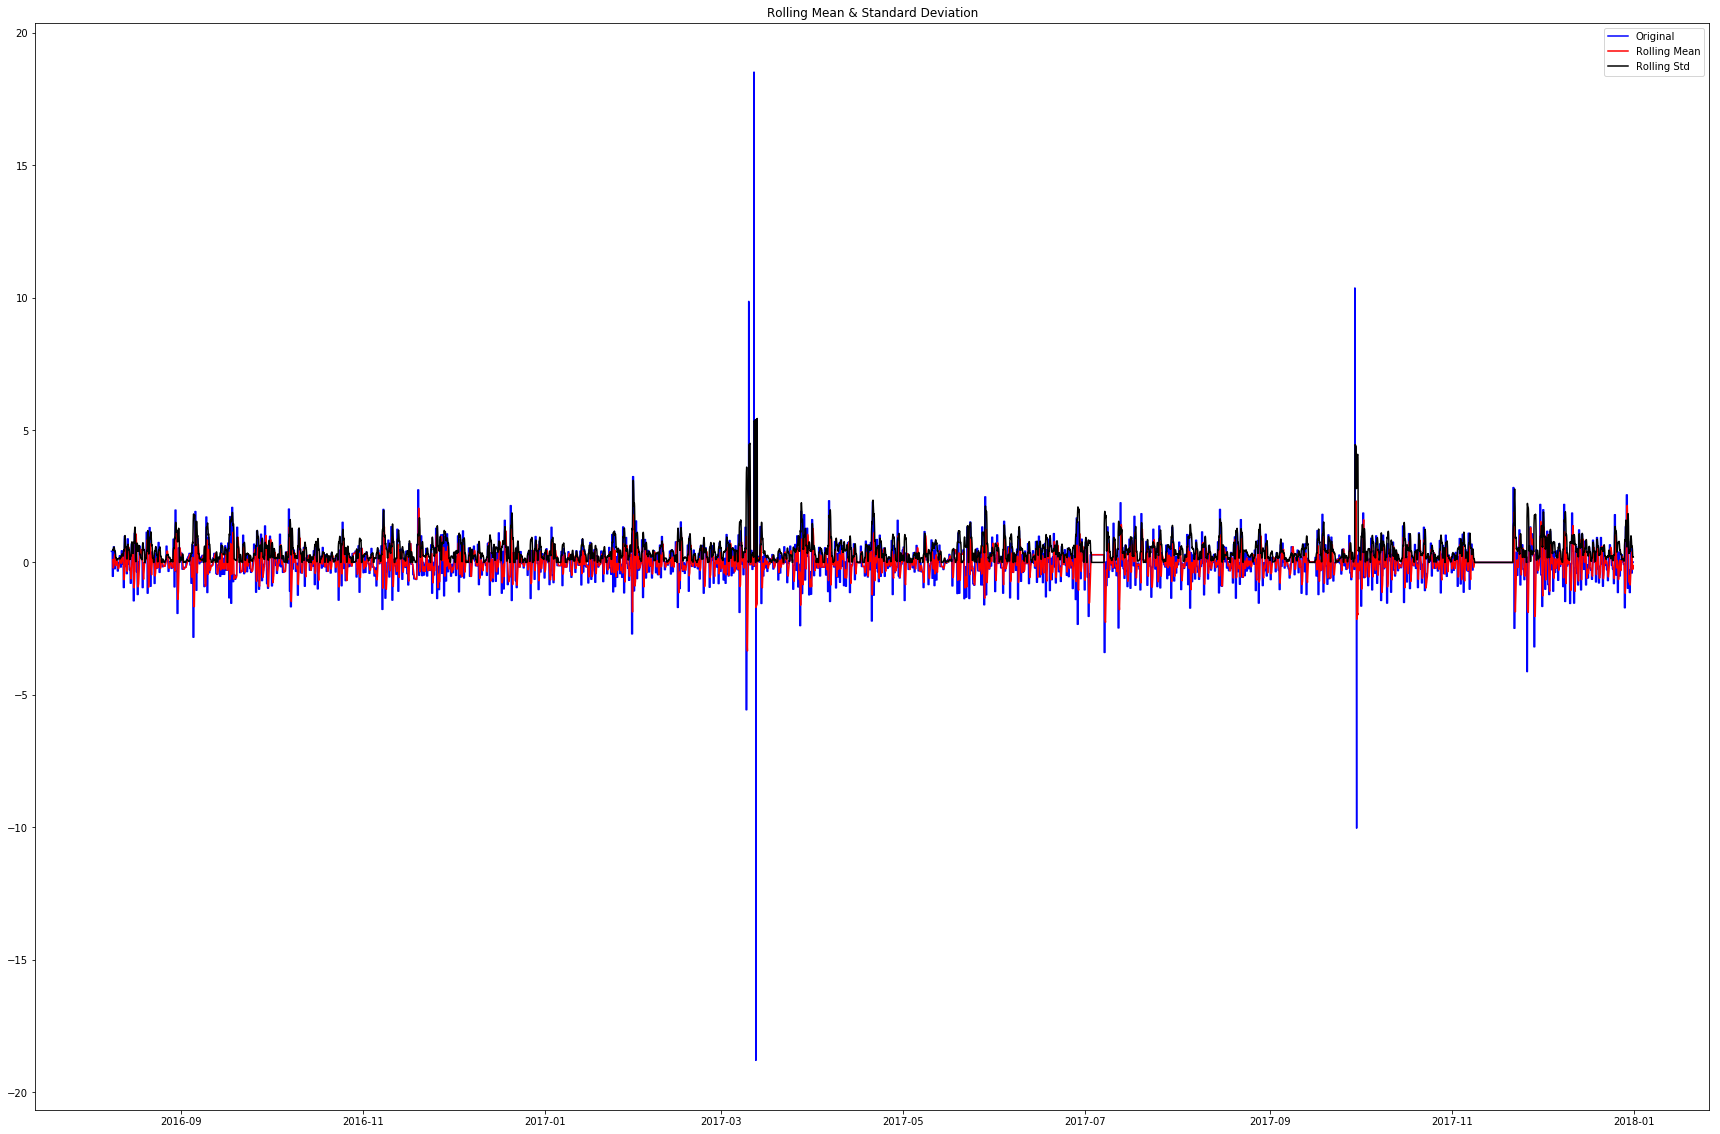

Results of Dickey-Fuller Test:
Test Statistic                   -23.204016
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12199.000000
Critical Value (1%)               -3.430886
Critical Value (5%)               -2.861777
Critical Value (10%)              -2.566896
dtype: float64


In [12]:
#hourly stationarization check, hourly differencing might work. Check others.
fd = difference_n(hourly,1)
test_stationarity(fd)

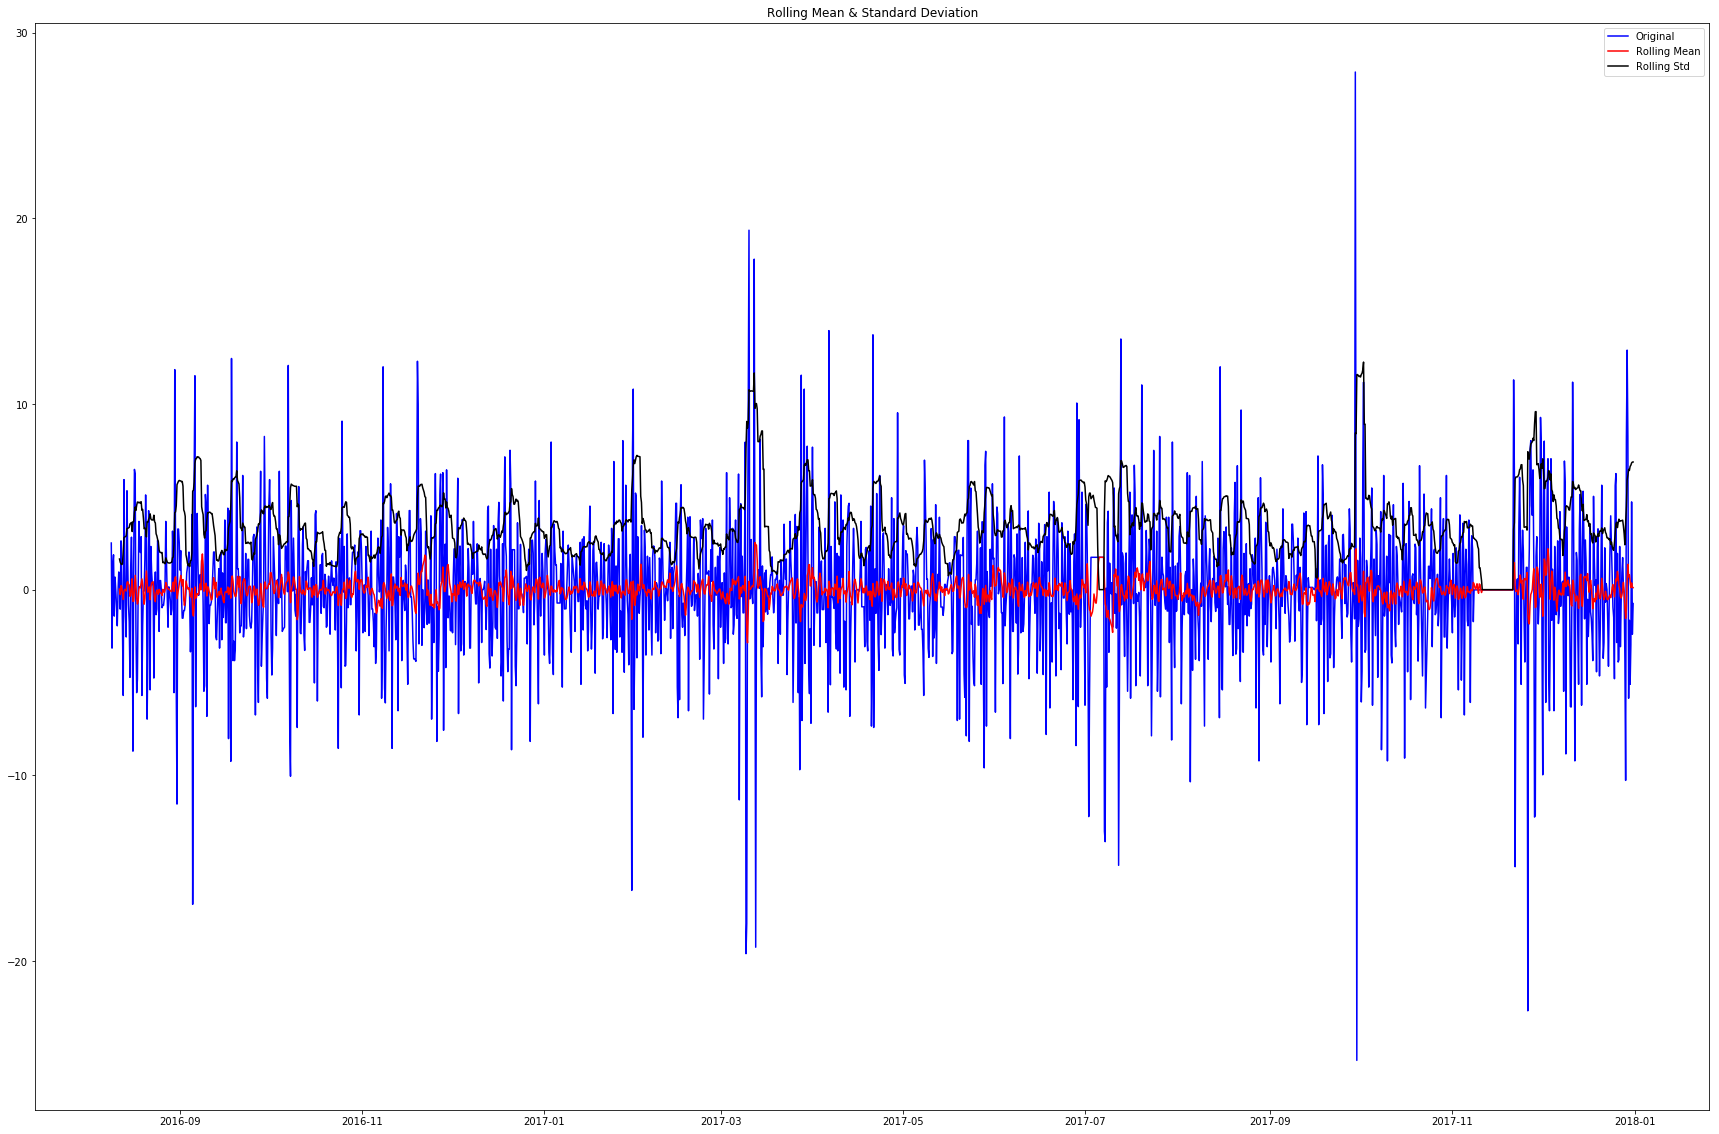

Results of Dickey-Fuller Test:
Test Statistic                -1.240638e+01
p-value                        4.442951e-23
#Lags Used                     2.600000e+01
Number of Observations Used    2.012000e+03
Critical Value (1%)           -3.433604e+00
Critical Value (5%)           -2.862978e+00
Critical Value (10%)          -2.567535e+00
dtype: float64


In [13]:
fd = difference_n(hourly_6,1)
test_stationarity(fd)

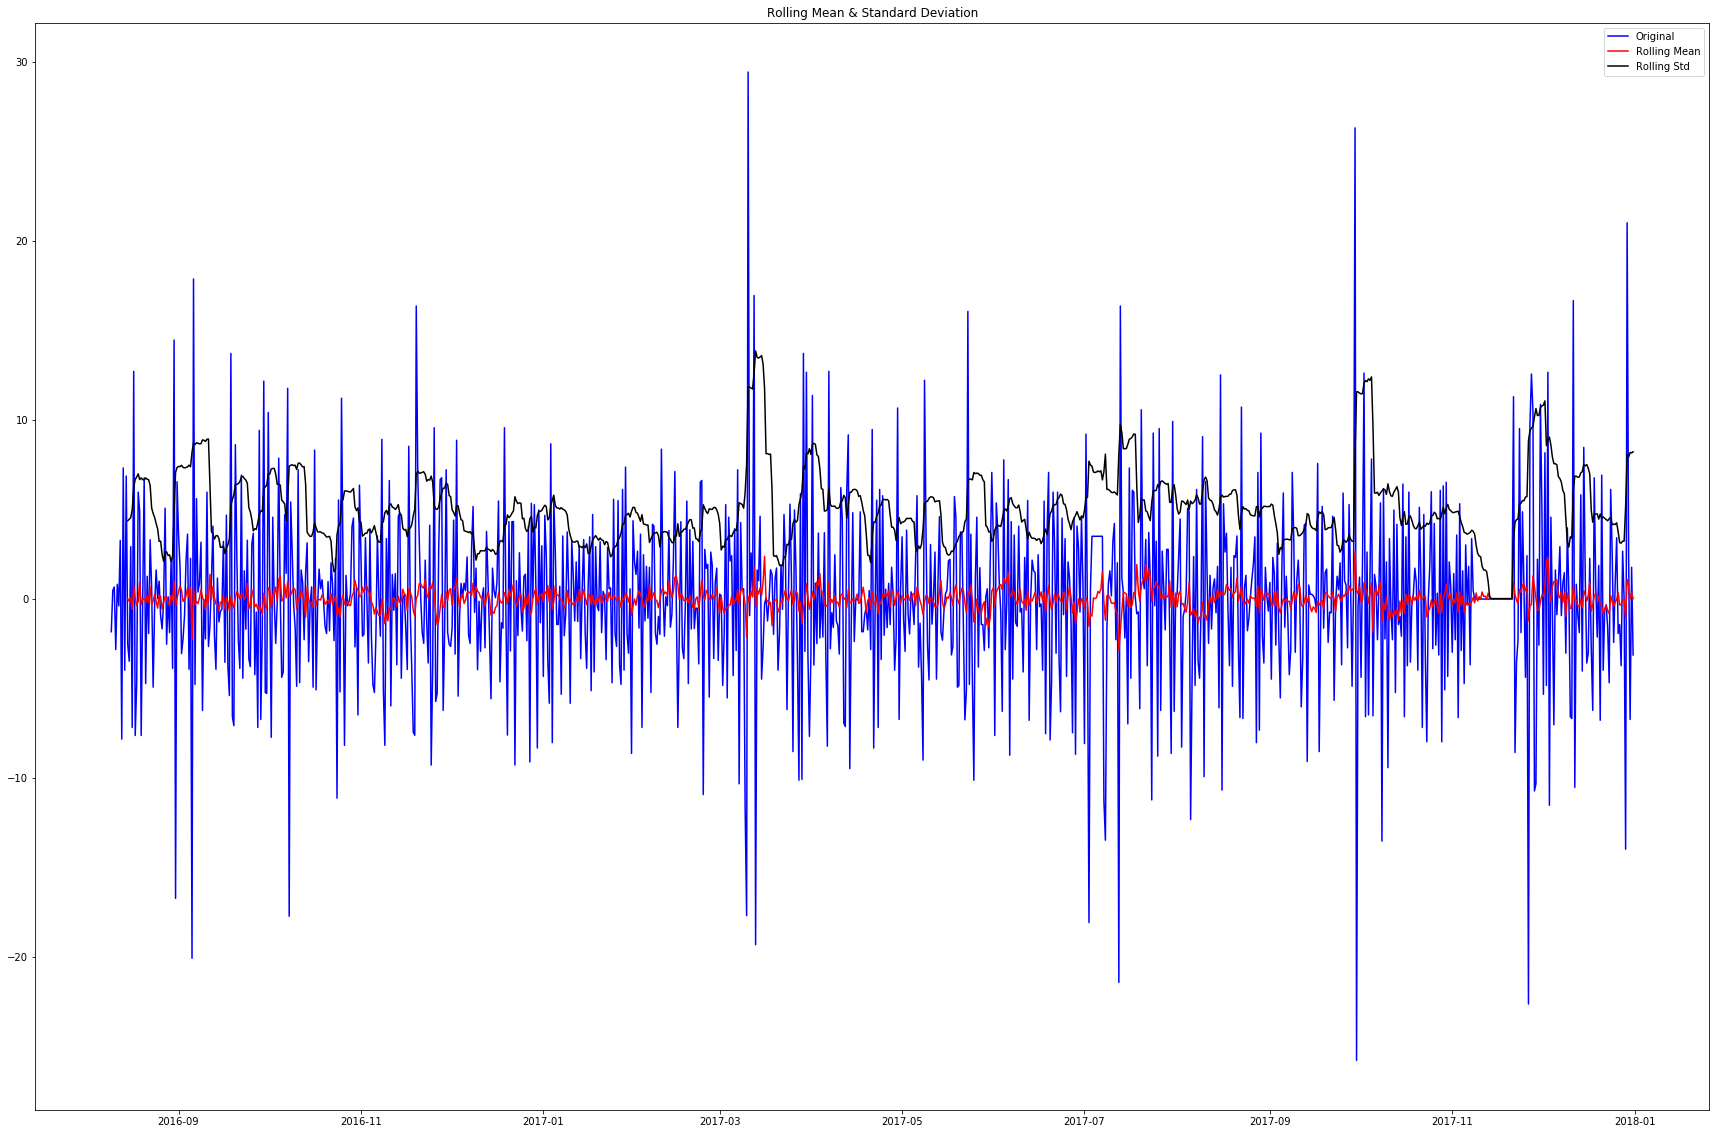

Results of Dickey-Fuller Test:
Test Statistic                -1.498697e+01
p-value                        1.140069e-27
#Lags Used                     9.000000e+00
Number of Observations Used    1.009000e+03
Critical Value (1%)           -3.436848e+00
Critical Value (5%)           -2.864409e+00
Critical Value (10%)          -2.568297e+00
dtype: float64


In [14]:
fd = difference_n(hourly_12,1)
test_stationarity(fd)

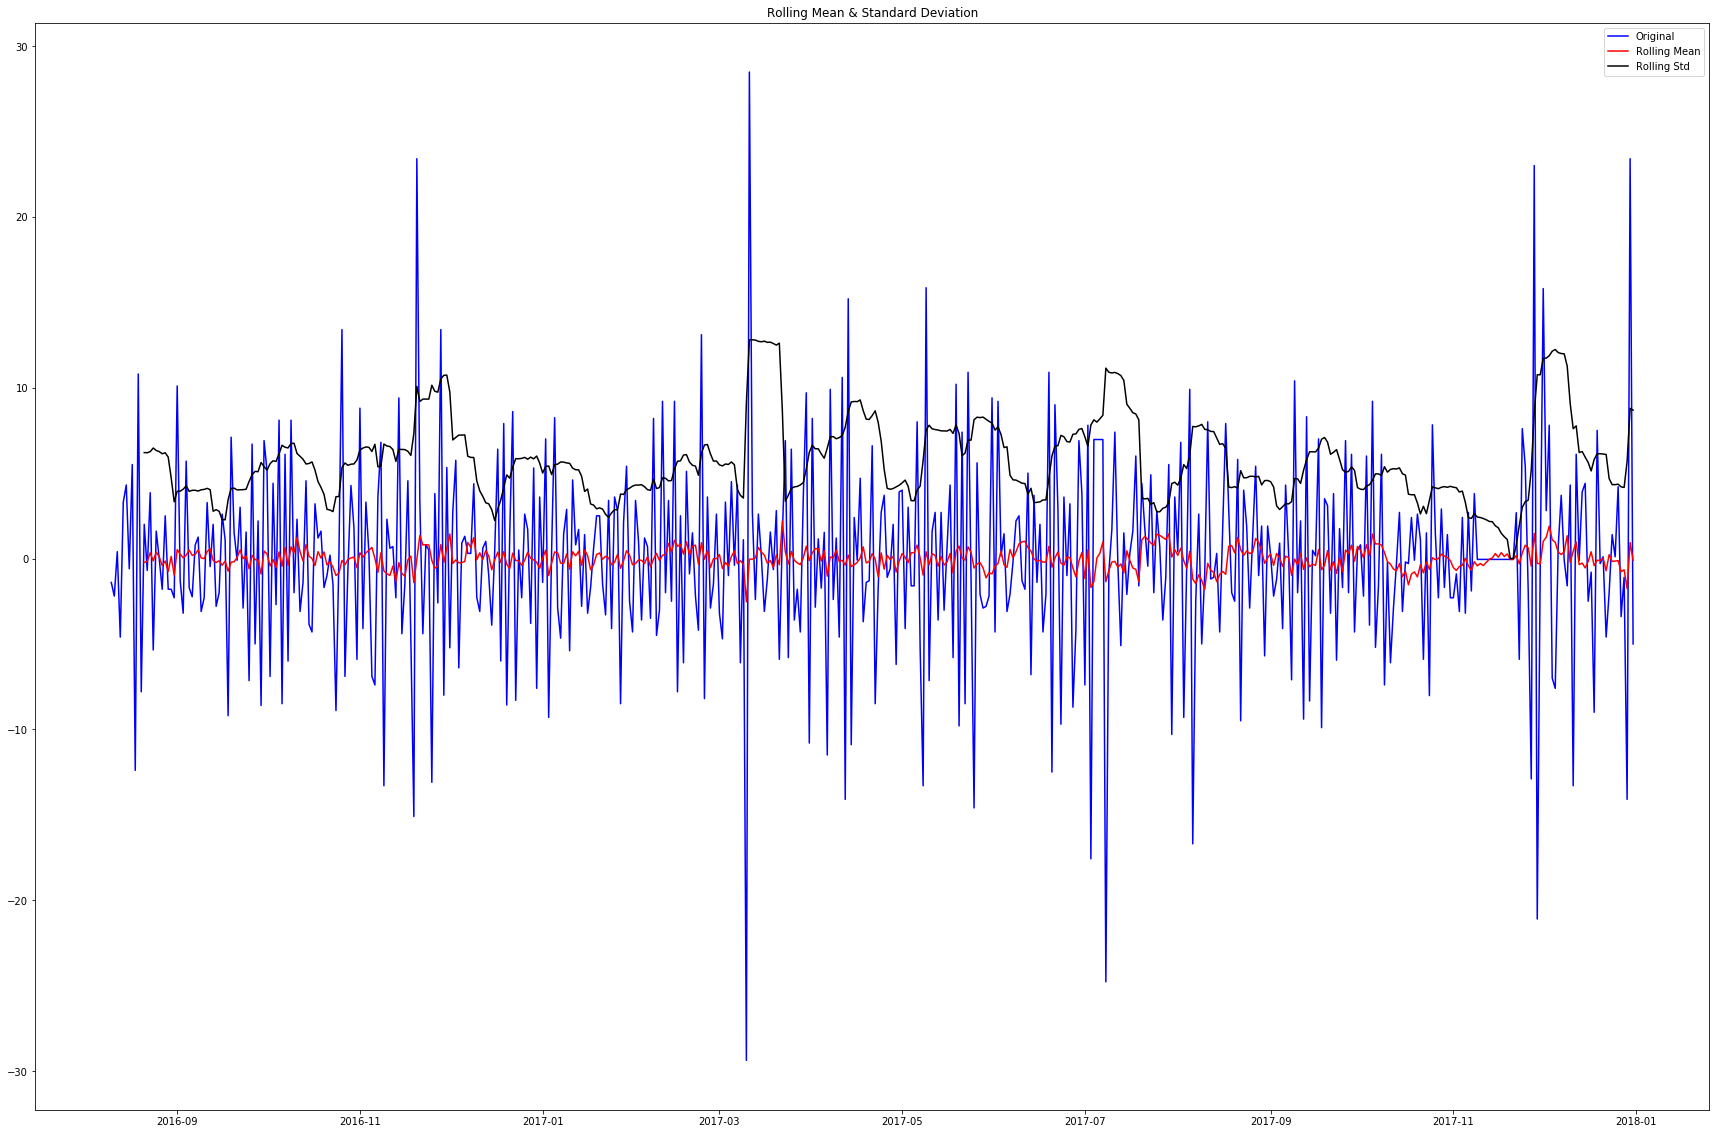

Results of Dickey-Fuller Test:
Test Statistic                -1.451797e+01
p-value                        5.584400e-27
#Lags Used                     5.000000e+00
Number of Observations Used    5.030000e+02
Critical Value (1%)           -3.443418e+00
Critical Value (5%)           -2.867303e+00
Critical Value (10%)          -2.569840e+00
dtype: float64


In [15]:
fd = difference_n(daily,1)
test_stationarity(fd)

In [16]:
#cleanup
del hourly, hourly_6, hourly_12, daily, fd;gc.collect()

20685

In [17]:
#difference 1 hour(60 mins) from original series
diff_1hr = difference_n(tr.Target.copy(),4)

In [18]:
#Best p-value for differencing is for 1 hourly differencing.
#First split to train and test
y_tr, y_ts = single_ts_split(diff_1hr, test_size=0.3)

In [19]:
#Fit auto arima with seasonal diff 4(hourly -> 15*4) to original series.
swm = auto_arima(y_tr,
                start_p=0,
                start_q=0,
                start_d=0,
                max_p=4,
                max_q=4,
                max_d=4,
                seasonal=False,
                trace=True,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=False,
                random=True,
                n_jobs=-1,
                random_state=NB_SEED)

Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

Fit ARIMA: order=(0, 0, 0); AIC=78530.245, BIC=78547.129, Fit time=0.175 seconds
Fit ARIMA: order=(3, 0, 0); AIC=-56800.274, BIC=-56758.064, Fit time=11.714 seconds
Fit ARIMA: order=(2, 0, 0); AIC=-53653.435, BIC=-53619.667, Fit time=13.821 seconds
Fit ARIMA: order=(4, 0, 1); AIC=-58922.836, BIC=-58863.742, Fit time=37.263 seconds
Fit ARIMA: order=(2, 0, 2); AIC=-60296.111, BIC=-60245.459, Fit time=39.063 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-55497.592, BIC=-55455.382, Fit time=47.129 seconds
Fit ARIMA: order=(3, 0, 3); AIC=-71392.169, BIC=-71324.633, Fit time=73.627 seconds
Fit ARIMA: order=(2, 0, 3); AIC=-71313.608, BIC=-71254.514, Fit time=75.436 seconds


/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Total fit time: 84.177 seconds


In [20]:
swm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                34269
Model:                     ARMA(3, 3)   Log Likelihood               35704.085
Method:                       css-mle   S.D. of innovations              0.085
Date:                Sat, 15 Dec 2018   AIC                         -71392.169
Time:                        18:28:17   BIC                         -71324.633
Sample:                             0   HQIC                        -71370.636
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0119      0.018     -0.667      0.505      -0.047       0.023
ar.L1.y        0.9497      0.005    198.758      0.000       0.940       0.959
ar.L2.y       -0.0019      0.006     -0.336      0.737      -0.013       0.009
ar.L3.y       -0.0516      0.005    -10.798      0.000      -0.061      -0.042
ma.L1.y        0.9986        nan        nan        nan         nan         nan
ma.L2.y        0.9995      0.001   1853.007      0.000       0.998       1.001
ma.L3.y        0.9984        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1349           +0.0000j            1.1349            0.0000
AR.2            3.5896           +0.0000j            3.5896            0.0000
AR.3           -4.7617           +0.0000j            4.7617            0.5000
MA.1           -1.0013           -0.0000j            1.0013           -0.5000
MA.2            0.0001           -1.0002j            1.0002           -0.2500
MA.3            0.0001           +1.0002j            1.0002            0.2500
-----------------------------------------------------------------------------
"""

In [21]:
y_pred = swm.predict(n_periods=100)
y_pred = pd.Series(data=y_pred)

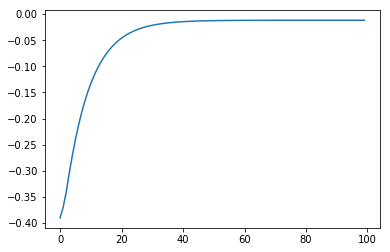

In [22]:
y_pred.plot()

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
y_tr, y_ts = single_ts_split(tr.Target.copy(), test_size=0.3)

In [ ]:
hw = ExponentialSmoothing(y_tr, trend='add', seasonal='add', seasonal_periods=4)

In [ ]:
fitted = hw.fit(optimized=True)

In [ ]:
fitted.params

In [ ]:
y_pred = hw.predict(fitted.params,start=min(y_ts.index), end=max(y_ts.index))
y_pred = pd.Series(data=y_pred, index=y_ts.index)

In [ ]:
y_ts.plot()
y_pred.plot()

In [ ]:
hw_mul = ExponentialSmoothing(y_tr, trend='mul', seasonal='mul', seasonal_periods=4)

In [ ]:
f_mul = hw_mul.fit(optimized=True)

In [ ]:
y_pred_mul = hw_mul.predict(f_mul.params, start=min(y_ts.index), end=max(y_ts.index))
y_pred_mul = pd.Series(data=y_pred_mul, index=y_ts.index)

In [ ]:
y_ts.plot()
y_pred_mul.plot()

In [ ]:
hw_add_mul = ExponentialSmoothing(y_tr, trend='add',seasonal='mul', seasonal_periods=4)

In [ ]:
f_add_mul = hw_add_mul.fit(optimized=True)

In [ ]:
y_pred_add_mul = hw_mul.predict(f_add_mul.params, start=min(y_ts.index), end=max(y_ts.index))
y_pred_add_mul = pd.Series(data=y_pred_add_mul, index=y_ts.index)

In [ ]:
y_ts.plot()
y_pred_add_mul.plot()

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
hw_trend = ExponentialSmoothing(y_tr, trend='add')

In [ ]:
f_hw_t = hw_trend.fit(optimized=True)

In [ ]:
y_pred_trend = hw_trend.predict(f_hw_t.params,start=min(y_ts.index), end=max(y_ts.index))
y_pred_trend = pd.Series(data=y_pred_trend, index=y_ts.index)

In [ ]:
y_ts.plot()
y_pred_trend.plot()

In [ ]:
hw_large_seas = ExponentialSmoothing(y_tr,trend='add',seasonal='add',seasonal_periods=24)

In [ ]:
f_hw_l_s = hw_large_seas.fit(optimized=True)

In [ ]:
y_pred_ls = hw_large_seas.predict(f_hw_l_s.params,start=min(y_ts.index), end=max(y_ts.index))
y_pred_ls = pd.Series(data=y_pred_ls, index=y_ts.index)

In [ ]:
y_ts.plot()
y_pred_ls.plot()